In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

In [2]:
df = pd.read_csv('Data.csv')

In [22]:
percent_missing = (df.isnull().sum())/(df.shape[0]) * 100
percent_missing

Ware_house_ID                    0.000
WH_Manager_ID                    0.000
Location_type                    0.000
WH_capacity_size                 0.000
zone                             0.000
WH_regional_zone                 0.000
num_refill_req_l3m               0.000
transport_issue_l1y              0.000
Competitor_in_mkt                0.000
retail_shop_num                  0.000
wh_owner_type                    0.000
distributor_num                  0.000
flood_impacted                   0.000
flood_proof                      0.000
electric_supply                  0.000
dist_from_hub                    0.000
workers_num                      3.960
wh_est_year                     47.524
storage_issue_reported_l3m       0.000
temp_reg_mach                    0.000
approved_wh_govt_certificate     3.632
wh_breakdown_l3m                 0.000
govt_check_l3m                   0.000
product_wg_ton                   0.000
n_missing                        0.000
dtype: float64

## What are the counts of missing values in train vs. test?

In [10]:
ncounts = pd.DataFrame(df.isna().mean())
ncounts.columns = ['Missing']

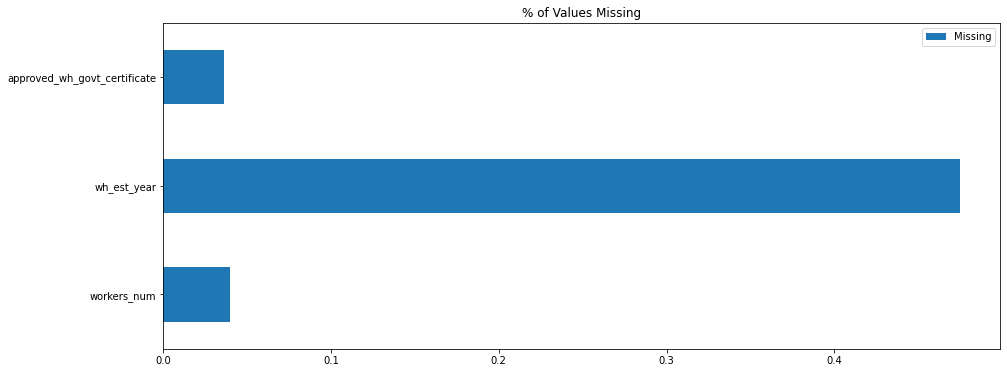

In [13]:
ncounts.query("Missing > 0").plot(
    kind='barh', figsize=(15, 6), title='% of Values Missing'
)
plt.show()

In [14]:
nacols = ['approved_wh_govt_certificate', 'wh_est_year', 'workers_num']

## How many missing values per observation?

In [15]:
df['n_missing'] = df[nacols].isna().sum(axis=1)

<AxesSubplot:title={'center':'Number of Missing Values per Sample'}>

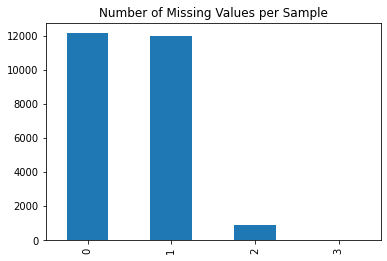

In [16]:
df["n_missing"].value_counts().plot(
    kind="bar", title="Number of Missing Values per Sample"
)

In [17]:
df.query("n_missing == 3")

,Ware_house_ID,WH_Manager_ID,Location_type,WH_capacity_size,zone,WH_regional_zone,num_refill_req_l3m,transport_issue_l1y,Competitor_in_mkt,retail_shop_num,...,dist_from_hub,workers_num,wh_est_year,storage_issue_reported_l3m,temp_reg_mach,approved_wh_govt_certificate,wh_breakdown_l3m,govt_check_l3m,product_wg_ton,n_missing
453,WH_100453,EID_50453,Rural,Large,North,Zone 5,2,0,2,5637,...,136,NaN,NaN,0,0,NaN,0,17,3112,3
923,WH_100923,EID_50923,Rural,Small,West,Zone 1,2,2,4,5225,...,107,NaN,NaN,0,0,NaN,0,31,3080,3
2073,WH_102073,EID_52073,Rural,Large,South,Zone 5,0,0,2,5061,...,83,NaN,NaN,0,0,NaN,0,25,4058,3
2930,WH_102930,EID_52930,Rural,Large,West,Zone 6,3,3,2,4354,...,88,NaN,NaN,0,0,NaN,0,6,3130,3
4588,WH_104588,EID_54588,Rural,Mid,West,Zone 3,0,0,2,4928,...,168,NaN,NaN,0,0,NaN,0,19,5139,3
5319,WH_105319,EID_55319,Rural,Large,South,Zone 6,1,0,2,7127,...,210,NaN,NaN,0,0,NaN,0,29,3080,3
6129,WH_106129,EID_56129,Rural,Large,South,Zone 6,0,0,2,6470,...,237,NaN,NaN,0,0,NaN,0,29,6056,3
6717,WH_106717,EID_56717,Rural,Large,North,Zone 5,0,0,3,6177,...,182,NaN,NaN,0,0,NaN,0,14,3096,3
7439,WH_107439,EID_57439,Rural,Small,South,Zone 1,7,3,2,6858,...,186,NaN,NaN,0,0,NaN,0,21,3071,3
13461,WH_113461,EID_63461,Rural,Small,North,Zone 6,5,3,3,5111,...,134,NaN,NaN,0,0,NaN,0,8,3121,3


## Do we see an imbalance in missing values when splitting by other features?

In [21]:
cat_features = ["approved_wh_govt_certificate", "Location_type"]
df.groupby("Location_type")["n_missing"].agg(['mean', 'count'])

,mean,count
Location_type,,
Rural,0.556911,22957
Urban,0.486539,2043


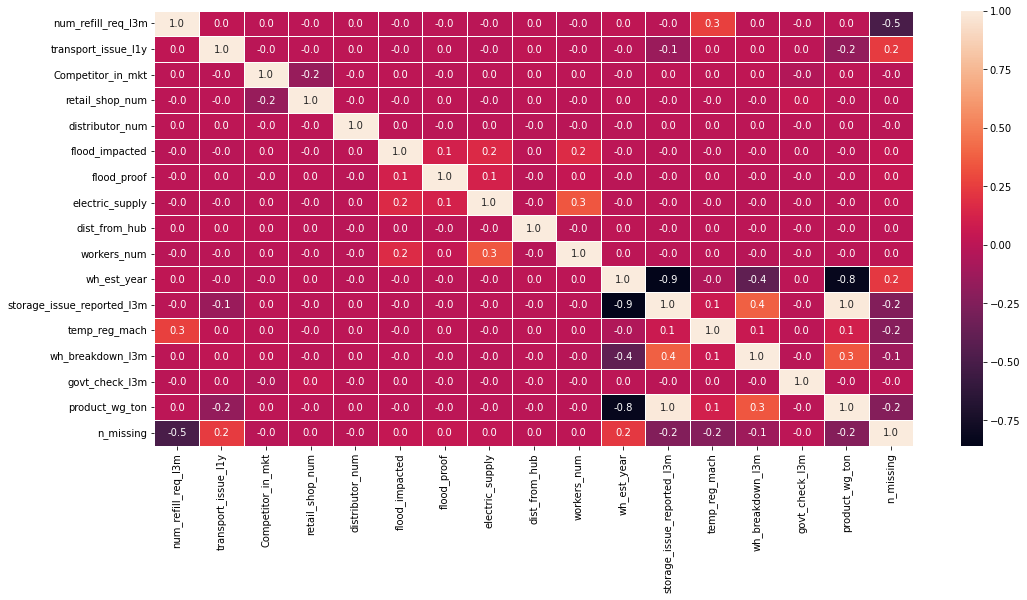

In [31]:
plt.figure(figsize=(17, 8))
sns.heatmap(df.corr(), annot=True, fmt=".1f", linewidth=.5)
plt.show()

In [32]:
df.corr()['n_missing']

num_refill_req_l3m           -0.496905
transport_issue_l1y           0.242693
Competitor_in_mkt            -0.014335
retail_shop_num               0.001353
distributor_num              -0.002867
flood_impacted                0.036181
flood_proof                   0.041978
electric_supply               0.023626
dist_from_hub                 0.002120
workers_num                   0.012300
wh_est_year                   0.227457
storage_issue_reported_l3m   -0.243062
temp_reg_mach                -0.231322
wh_breakdown_l3m             -0.132342
govt_check_l3m               -0.000257
product_wg_ton               -0.238342
n_missing                     1.000000
Name: n_missing, dtype: float64

In [33]:
missing_tag_df = df[nacols].isna()
missing_tag_df.columns = \
    [f"{c}_missing" for c in missing_tag_df.columns]

In [34]:
df = pd.concat([df, missing_tag_df], axis=1)

In [75]:
df.drop('approved_wh_govt_certificate_missing_mean_imp', axis=1, inplace=True)

In [43]:
alphas = np.logspace(-6, 6, 25)
ridge = RidgeCV(alphas=alphas)

X = df[
    [
        'approved_wh_govt_certificate_missing',
        'wh_est_year_missing',
        'workers_num_missing'
    ]
]

y = df['product_wg_ton']

ridge.fit(X, y)
score = ridge.score(X, y)

preds = ridge.predict(X)

print(mean_squared_error(y, preds))
print(mean_squared_error(y, preds, squared=False))
print(score)

120641274.60347797
10983.68219694461
0.10460056242034077


In [66]:
print(df["approved_wh_govt_certificate"].mode())

0    C
Name: approved_wh_govt_certificate, dtype: object


In [65]:
df["approved_wh_govt_certificate"].fillna(df["approved_wh_govt_certificate"].mode())

0         A
1         A
2         A
3        A+
4         C
         ..
24995     A
24996     B
24997    B+
24998     A
24999    B+
Name: approved_wh_govt_certificate, Length: 25000, dtype: object

In [69]:
df["approved_wh_govt_certificate_mode_imp"] = df["approved_wh_govt_certificate"].fillna(
    df["approved_wh_govt_certificate"].mode().iloc[0]
)

In [70]:
df.loc[(df['approved_wh_govt_certificate'].isna()), ["approved_wh_govt_certificate", "approved_wh_govt_certificate_mode_imp"]]

,approved_wh_govt_certificate,approved_wh_govt_certificate_mode_imp
28,NaN,C
35,NaN,C
38,NaN,C
99,NaN,C
117,NaN,C
...,...,...
24887,NaN,C
24897,NaN,C
24902,NaN,C
24934,NaN,C


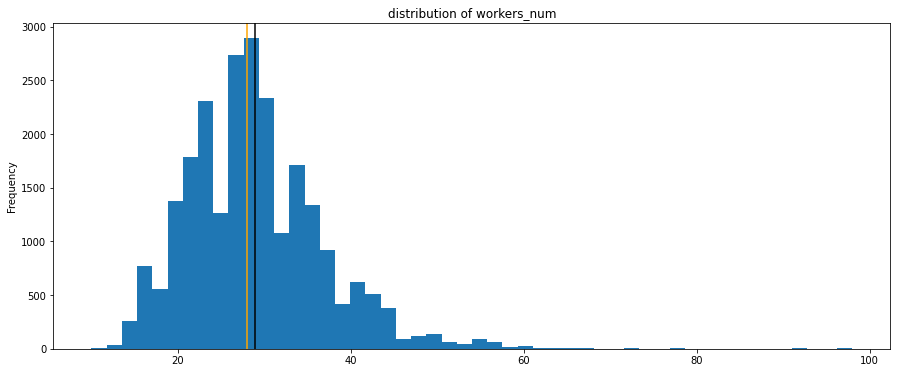

In [73]:
plt.figure(figsize=(15, 6))
ax = df['workers_num'] \
    .plot(kind='hist', bins=50,
          title='distribution of workers_num')
ax.axvline(df['workers_num'].mean(),
           color='black')
ax.axvline(df['workers_num'].median(),
           color='orange')
plt.show()

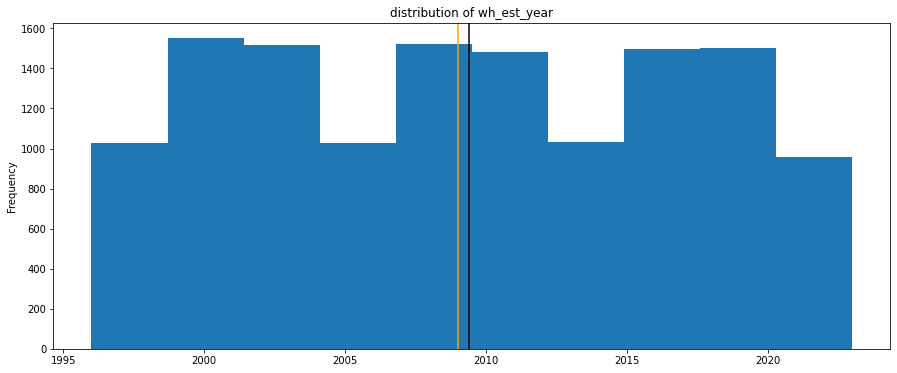

In [85]:
plt.figure(figsize=(15, 6))
ax = df['wh_est_year'] \
    .plot(kind='hist', title='distribution of wh_est_year')
ax.axvline(df['wh_est_year'].mean(),
           color='black')
ax.axvline(df['wh_est_year'].median(),
           color='orange')
plt.show()

In [90]:
df.columns

Index(['Ware_house_ID', 'WH_Manager_ID', 'Location_type', 'WH_capacity_size',
       'zone', 'WH_regional_zone', 'num_refill_req_l3m', 'transport_issue_l1y',
       'Competitor_in_mkt', 'retail_shop_num', 'wh_owner_type',
       'distributor_num', 'flood_impacted', 'flood_proof', 'electric_supply',
       'dist_from_hub', 'workers_num', 'wh_est_year',
       'storage_issue_reported_l3m', 'temp_reg_mach',
       'approved_wh_govt_certificate', 'wh_breakdown_l3m', 'govt_check_l3m',
       'product_wg_ton', 'n_missing', 'approved_wh_govt_certificate_missing',
       'wh_est_year_missing', 'workers_num_missing',
       'approved_wh_govt_certificate_mode_imp'],
      dtype='object')

In [94]:
m_i_cols = df.columns[-5:]

In [105]:
FEATURES = [col for col in df.columns if col not in m_i_cols]
FEATURES

['Ware_house_ID',
 'WH_Manager_ID',
 'Location_type',
 'WH_capacity_size',
 'zone',
 'WH_regional_zone',
 'num_refill_req_l3m',
 'transport_issue_l1y',
 'Competitor_in_mkt',
 'retail_shop_num',
 'wh_owner_type',
 'distributor_num',
 'flood_impacted',
 'flood_proof',
 'electric_supply',
 'dist_from_hub',
 'workers_num',
 'wh_est_year',
 'storage_issue_reported_l3m',
 'temp_reg_mach',
 'approved_wh_govt_certificate',
 'wh_breakdown_l3m',
 'govt_check_l3m',
 'product_wg_ton']

In [104]:
cat_cols = [col for col in df.columns if df[col].dtypes == 'object' and col not in ['approved_wh_govt_certificate_mode_imp']]
for col in cat_cols:
    le = LabelEncoder()
    df.loc[:, col] = le.fit_transform(df[col])

In [169]:
imptr = SimpleImputer(strategy="mean", add_indicator=False)
tr_imp = imptr.fit_transform(df[FEATURES])
tt_simple_impute = pd.DataFrame(tr_imp, columns=FEATURES)

In [178]:
model = LinearRegression()

cv_scores = cross_val_score(model, tt_simple_impute, y, cv=5, scoring='neg_mean_squared_error')
cv_mean_mse = np.mean(-cv_scores)

print('Cross-validation mean MSE:', cv_mean_mse)
print(cv_scores)

Cross-validation mean MSE: 8.54116094839592e-23
[-2.32921446e-22 -2.59170989e-23 -2.69162917e-23 -1.29132778e-22
 -1.21704324e-23]


In [109]:
tt_simple_impute

,Ware_house_ID,WH_Manager_ID,Location_type,WH_capacity_size,zone,WH_regional_zone,num_refill_req_l3m,transport_issue_l1y,Competitor_in_mkt,retail_shop_num,...,electric_supply,dist_from_hub,workers_num,wh_est_year,storage_issue_reported_l3m,temp_reg_mach,approved_wh_govt_certificate,wh_breakdown_l3m,govt_check_l3m,product_wg_ton
0,0.0,0.0,1.0,2.0,3.0,5.0,3.0,1.0,2.0,4651.0,...,1.0,91.0,29.000000,2009.383185,13.0,0.0,0.0,5.0,15.0,17115.0
1,1.0,1.0,0.0,0.0,1.0,4.0,0.0,0.0,4.0,6217.0,...,1.0,210.0,31.000000,2009.383185,4.0,0.0,0.0,3.0,17.0,5074.0
2,2.0,2.0,0.0,1.0,2.0,1.0,1.0,0.0,4.0,4306.0,...,0.0,161.0,37.000000,2009.383185,17.0,0.0,0.0,6.0,22.0,23137.0
3,3.0,3.0,0.0,1.0,1.0,2.0,7.0,4.0,2.0,6000.0,...,0.0,103.0,21.000000,2009.383185,17.0,1.0,1.0,3.0,27.0,22115.0
4,4.0,4.0,0.0,0.0,1.0,4.0,3.0,1.0,2.0,4740.0,...,1.0,112.0,25.000000,2009.000000,18.0,0.0,4.0,6.0,24.0,24071.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,24995.0,24995.0,0.0,2.0,1.0,0.0,3.0,0.0,4.0,5390.0,...,1.0,142.0,34.000000,2005.000000,22.0,1.0,0.0,2.0,30.0,32093.0
24996,24996.0,24996.0,0.0,1.0,3.0,1.0,6.0,0.0,4.0,4490.0,...,1.0,130.0,28.000000,2012.000000,10.0,0.0,2.0,4.0,18.0,12114.0
24997,24997.0,24997.0,1.0,0.0,2.0,4.0,7.0,0.0,2.0,5403.0,...,1.0,147.0,28.944398,2009.383185,23.0,0.0,3.0,5.0,25.0,27080.0
24998,24998.0,24998.0,0.0,2.0,1.0,0.0,1.0,0.0,2.0,10562.0,...,1.0,60.0,25.000000,2009.383185,18.0,0.0,0.0,6.0,30.0,25093.0


In [110]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

In [179]:
it_imputer = IterativeImputer(max_iter=10)
train_iterimp = it_imputer.fit_transform(df[FEATURES])
tt_iter_imp_df = pd.DataFrame(train_iterimp, columns=FEATURES)

In [180]:
model = LinearRegression()

cv_scores = cross_val_score(model, tt_iter_imp_df, y, cv=5, scoring='neg_mean_squared_error')
cv_mean_mse = np.mean(-cv_scores)

print('Cross-validation mean MSE:', cv_mean_mse)
print(cv_scores)

Cross-validation mean MSE: 1.1020335395141877e-22
[-2.78987507e-22 -1.58625531e-22 -1.64202383e-23 -7.01662158e-23
 -2.68172782e-23]


In [114]:
tt_iter_imp_df

,Ware_house_ID,WH_Manager_ID,Location_type,WH_capacity_size,zone,WH_regional_zone,num_refill_req_l3m,transport_issue_l1y,Competitor_in_mkt,retail_shop_num,...,electric_supply,dist_from_hub,workers_num,wh_est_year,storage_issue_reported_l3m,temp_reg_mach,approved_wh_govt_certificate,wh_breakdown_l3m,govt_check_l3m,product_wg_ton
0,0.0,0.0,1.0,2.0,3.0,5.0,3.0,1.0,2.0,4651.0,...,1.0,91.0,29.000000,2012.139431,13.0,0.0,0.0,5.0,15.0,17115.0
1,1.0,1.0,0.0,0.0,1.0,4.0,0.0,0.0,4.0,6217.0,...,1.0,210.0,31.000000,2019.127114,4.0,0.0,0.0,3.0,17.0,5074.0
2,2.0,2.0,0.0,1.0,2.0,1.0,1.0,0.0,4.0,4306.0,...,0.0,161.0,37.000000,2010.214822,17.0,0.0,0.0,6.0,22.0,23137.0
3,3.0,3.0,0.0,1.0,1.0,2.0,7.0,4.0,2.0,6000.0,...,0.0,103.0,21.000000,2009.374484,17.0,1.0,1.0,3.0,27.0,22115.0
4,4.0,4.0,0.0,0.0,1.0,4.0,3.0,1.0,2.0,4740.0,...,1.0,112.0,25.000000,2009.000000,18.0,0.0,4.0,6.0,24.0,24071.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,24995.0,24995.0,0.0,2.0,1.0,0.0,3.0,0.0,4.0,5390.0,...,1.0,142.0,34.000000,2005.000000,22.0,1.0,0.0,2.0,30.0,32093.0
24996,24996.0,24996.0,0.0,1.0,3.0,1.0,6.0,0.0,4.0,4490.0,...,1.0,130.0,28.000000,2012.000000,10.0,0.0,2.0,4.0,18.0,12114.0
24997,24997.0,24997.0,1.0,0.0,2.0,4.0,7.0,0.0,2.0,5403.0,...,1.0,147.0,32.364677,2004.934287,23.0,0.0,3.0,5.0,25.0,27080.0
24998,24998.0,24998.0,0.0,2.0,1.0,0.0,1.0,0.0,2.0,10562.0,...,1.0,60.0,25.000000,2009.600012,18.0,0.0,0.0,6.0,30.0,25093.0


In [181]:
from sklearn.impute import KNNImputer

knn_imptr = KNNImputer(n_neighbors=5)
train_knnimp = knn_imptr.fit_transform(df[FEATURES])
knn_imp_df = pd.DataFrame(train_knnimp, columns=FEATURES)

In [182]:
model = LinearRegression()

cv_scores = cross_val_score(model, knn_imp_df, y, cv=5, scoring='neg_mean_squared_error')
cv_mean_mse = np.mean(-cv_scores)

print('Cross-validation mean MSE:', cv_mean_mse)
print(cv_scores)

Cross-validation mean MSE: 4.0254529442933824e-23
[-2.05688385e-23 -9.00868343e-23 -3.18445097e-23 -3.13259915e-23
 -2.74464731e-23]


In [121]:
knn_imp_df

,Ware_house_ID,WH_Manager_ID,Location_type,WH_capacity_size,zone,WH_regional_zone,num_refill_req_l3m,transport_issue_l1y,Competitor_in_mkt,retail_shop_num,...,electric_supply,dist_from_hub,workers_num,wh_est_year,storage_issue_reported_l3m,temp_reg_mach,approved_wh_govt_certificate,wh_breakdown_l3m,govt_check_l3m,product_wg_ton
0,0.0,0.0,1.0,2.0,3.0,5.0,3.0,1.0,2.0,4651.0,...,1.0,91.0,29.0,2015.0,13.0,0.0,0.0,5.0,15.0,17115.0
1,1.0,1.0,0.0,0.0,1.0,4.0,0.0,0.0,4.0,6217.0,...,1.0,210.0,31.0,2021.6,4.0,0.0,0.0,3.0,17.0,5074.0
2,2.0,2.0,0.0,1.0,2.0,1.0,1.0,0.0,4.0,4306.0,...,0.0,161.0,37.0,2009.6,17.0,0.0,0.0,6.0,22.0,23137.0
3,3.0,3.0,0.0,1.0,1.0,2.0,7.0,4.0,2.0,6000.0,...,0.0,103.0,21.0,2008.4,17.0,1.0,1.0,3.0,27.0,22115.0
4,4.0,4.0,0.0,0.0,1.0,4.0,3.0,1.0,2.0,4740.0,...,1.0,112.0,25.0,2009.0,18.0,0.0,4.0,6.0,24.0,24071.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,24995.0,24995.0,0.0,2.0,1.0,0.0,3.0,0.0,4.0,5390.0,...,1.0,142.0,34.0,2005.0,22.0,1.0,0.0,2.0,30.0,32093.0
24996,24996.0,24996.0,0.0,1.0,3.0,1.0,6.0,0.0,4.0,4490.0,...,1.0,130.0,28.0,2012.0,10.0,0.0,2.0,4.0,18.0,12114.0
24997,24997.0,24997.0,1.0,0.0,2.0,4.0,7.0,0.0,2.0,5403.0,...,1.0,147.0,22.8,2009.6,23.0,0.0,3.0,5.0,25.0,27080.0
24998,24998.0,24998.0,0.0,2.0,1.0,0.0,1.0,0.0,2.0,10562.0,...,1.0,60.0,25.0,2005.4,18.0,0.0,0.0,6.0,30.0,25093.0


In [122]:
!git clone https://github.com/analokmaus/kuma_utils.git

Cloning into 'kuma_utils'...


In [123]:
import sys
sys.path.append("kuma_utils/")
from kuma_utils.preprocessing.imputer import LGBMImputer

In [125]:
lgbm_imtr = LGBMImputer(n_iter=100, verbose=True)

train_lgbmimp = lgbm_imtr.fit_transform(df[FEATURES])

  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_sto

In [127]:
lgbm_imp_df = pd.DataFrame(train_lgbmimp, columns=FEATURES)

In [183]:
model = LinearRegression()

cv_scores = cross_val_score(model, lgbm_imp_df, y, cv=5, scoring='neg_mean_squared_error')
cv_mean_mse = np.mean(-cv_scores)

print('Cross-validation mean MSE:', cv_mean_mse)
print(cv_scores)

Cross-validation mean MSE: 5.204459941144814e-23
[-8.54530926e-23 -1.67231932e-23 -3.58696946e-23 -1.16652691e-22
 -5.52432572e-24]


In [128]:
lgbm_imp_df

,Ware_house_ID,WH_Manager_ID,Location_type,WH_capacity_size,zone,WH_regional_zone,num_refill_req_l3m,transport_issue_l1y,Competitor_in_mkt,retail_shop_num,...,electric_supply,dist_from_hub,workers_num,wh_est_year,storage_issue_reported_l3m,temp_reg_mach,approved_wh_govt_certificate,wh_breakdown_l3m,govt_check_l3m,product_wg_ton
0,0,0,1,2,3,5,3,1,2,4651,...,1,91,29.000000,2014.463055,13,0,0,5,15,17115
1,1,1,0,0,1,4,0,0,4,6217,...,1,210,31.000000,2020.161292,4,0,0,3,17,5074
2,2,2,0,1,2,1,1,0,4,4306,...,0,161,37.000000,2009.705999,17,0,0,6,22,23137
3,3,3,0,1,1,2,7,4,2,6000,...,0,103,21.000000,2007.234993,17,1,1,3,27,22115
4,4,4,0,0,1,4,3,1,2,4740,...,1,112,25.000000,2009.000000,18,0,4,6,24,24071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,24995,24995,0,2,1,0,3,0,4,5390,...,1,142,34.000000,2005.000000,22,1,0,2,30,32093
24996,24996,24996,0,1,3,1,6,0,4,4490,...,1,130,28.000000,2012.000000,10,0,2,4,18,12114
24997,24997,24997,1,0,2,4,7,0,2,5403,...,1,147,33.969983,2003.297858,23,0,3,5,25,27080
24998,24998,24998,0,2,1,0,1,0,2,10562,...,1,60,25.000000,2010.300751,18,0,0,6,30,25093


In [131]:
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']

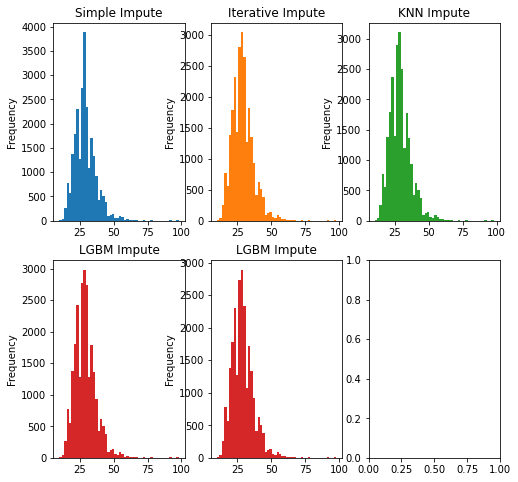

In [166]:
fig, axs = plt.subplots(2, 3, figsize=(8, 8))
axs = axs.flatten()

tt_simple_impute['workers_num'] \
    .plot(kind='hist',
          bins=50,
          ax=axs[0],
          title='Simple Impute',
          color=color_pal[0])

tt_iter_imp_df['workers_num'] \
    .plot(kind='hist',
          bins=50,
          ax=axs[1],
          title='Iterative Impute',
         color=color_pal[1])

knn_imp_df['workers_num'] \
    .plot(kind='hist',
          bins=50,
          ax=axs[2],
          title='KNN Impute',
         color=color_pal[2])

lgbm_imp_df['workers_num'] \
    .plot(kind='hist',
          bins=50,
          ax=axs[3],
          title='LGBM Impute',
         color=color_pal[3])

df['workers_num'] \
    .plot(kind='hist',
          bins=50,
          ax=axs[4],
          title='LGBM Impute',
         color=color_pal[3])
plt.show()

In [159]:
print(df['workers_num'].describe())
print(end="\n")
print(tt_simple_impute['workers_num'].describe())
print(end="\n")
print(tt_iter_imp_df['workers_num'].describe())
print(end="\n")
print(knn_imp_df['workers_num'].describe())
print(end="\n")
print(lgbm_imp_df['workers_num'].describe())

count    24010.000000
mean        28.944398
std          7.872534
min         10.000000
25%         24.000000
50%         28.000000
75%         33.000000
max         98.000000
Name: workers_num, dtype: float64

count    25000.000000
mean        28.944398
std          7.715077
min         10.000000
25%         24.000000
50%         28.000000
75%         33.000000
max         98.000000
Name: workers_num, dtype: float64

count    25000.000000
mean        28.969498
std          7.737600
min         10.000000
25%         24.000000
50%         28.000000
75%         33.000000
max         98.000000
Name: workers_num, dtype: float64

count    25000.000000
mean        28.935256
std          7.745362
min         10.000000
25%         24.000000
50%         28.000000
75%         33.000000
max         98.000000
Name: workers_num, dtype: float64

count    25000.000000
mean        28.977362
std          7.744274
min         10.000000
25%         24.000000
50%         28.000000
75%         33.000000
ma

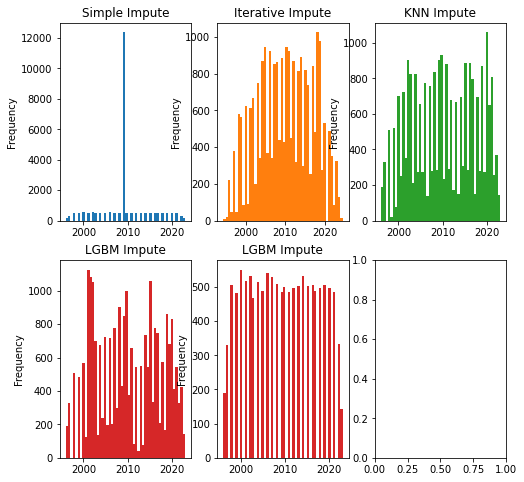

In [165]:
fig, axs = plt.subplots(2, 3, figsize=(8, 8))
axs = axs.flatten()

tt_simple_impute['wh_est_year'] \
    .plot(kind='hist',
          bins=50,
          ax=axs[0],
          title='Simple Impute',
          color=color_pal[0])

tt_iter_imp_df['wh_est_year'] \
    .plot(kind='hist',
          bins=50,
          ax=axs[1],
          title='Iterative Impute',
         color=color_pal[1])

knn_imp_df['wh_est_year'] \
    .plot(kind='hist',
          bins=50,
          ax=axs[2],
          title='KNN Impute',
         color=color_pal[2])

lgbm_imp_df['wh_est_year'] \
    .plot(kind='hist',
          bins=50,
          ax=axs[3],
          title='LGBM Impute',
         color=color_pal[3])

df['wh_est_year'] \
    .plot(kind='hist',
          bins=50,
          ax=axs[4],
          title='LGBM Impute',
         color=color_pal[3])
plt.show()

In [160]:
print(df['wh_est_year'].describe())
print(end="\n")
print(tt_simple_impute['wh_est_year'].describe())
print(end="\n")
print(tt_iter_imp_df['wh_est_year'].describe())
print(end="\n")
print(knn_imp_df['wh_est_year'].describe())
print(end="\n")
print(lgbm_imp_df['wh_est_year'].describe())

count    13119.000000
mean      2009.383185
std          7.528230
min       1996.000000
25%       2003.000000
50%       2009.000000
75%       2016.000000
max       2023.000000
Name: wh_est_year, dtype: float64

count    25000.000000
mean      2009.383185
std          5.453375
min       1996.000000
25%       2009.000000
50%       2009.383185
75%       2010.000000
max       2023.000000
Name: wh_est_year, dtype: float64

count    25000.000000
mean      2010.003676
std          6.898880
min       1994.366495
25%       2004.782841
50%       2010.000000
75%       2016.000000
max       2024.414523
Name: wh_est_year, dtype: float64

count    25000.000000
mean      2010.332408
std          7.202470
min       1996.000000
25%       2004.000000
50%       2010.000000
75%       2016.600000
max       2023.000000
Name: wh_est_year, dtype: float64

count    25000.000000
mean      2009.980955
std          7.205957
min       1996.000000
25%       2003.324538
50%       2009.705250
75%       2016.000000
ma

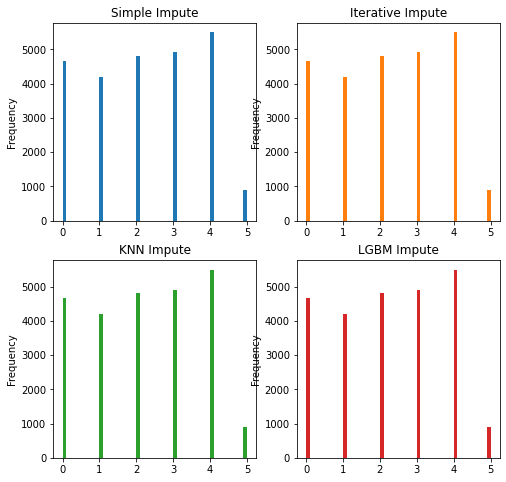

In [161]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs = axs.flatten()

tt_simple_impute['approved_wh_govt_certificate'] \
    .plot(kind='hist',
          bins=50,
          ax=axs[0],
          title='Simple Impute',
          color=color_pal[0])

tt_iter_imp_df['approved_wh_govt_certificate'] \
    .plot(kind='hist',
          bins=50,
          ax=axs[1],
          title='Iterative Impute',
         color=color_pal[1])

knn_imp_df['approved_wh_govt_certificate'] \
    .plot(kind='hist',
          bins=50,
          ax=axs[2],
          title='KNN Impute',
         color=color_pal[2])

lgbm_imp_df['approved_wh_govt_certificate'] \
    .plot(kind='hist',
          bins=50,
          ax=axs[3],
          title='LGBM Impute',
         color=color_pal[3])
plt.show()

In [162]:
print(df['approved_wh_govt_certificate'].describe())
print(end="\n")
print(tt_simple_impute['approved_wh_govt_certificate'].describe())
print(end="\n")
print(tt_iter_imp_df['approved_wh_govt_certificate'].describe())
print(end="\n")
print(knn_imp_df['approved_wh_govt_certificate'].describe())
print(end="\n")
print(lgbm_imp_df['approved_wh_govt_certificate'].describe())

count    25000.000000
mean         2.204400
std          1.508984
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max          5.000000
Name: approved_wh_govt_certificate, dtype: float64

count    25000.000000
mean         2.204400
std          1.508984
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max          5.000000
Name: approved_wh_govt_certificate, dtype: float64

count    25000.000000
mean         2.204400
std          1.508984
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max          5.000000
Name: approved_wh_govt_certificate, dtype: float64

count    25000.000000
mean         2.204400
std          1.508984
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max          5.000000
Name: approved_wh_govt_certificate, dtype: float64

count    25000.000000
mean         2.204400
std          1.508984
min          0.000000


In [184]:
lgbm_imp_df

,Ware_house_ID,WH_Manager_ID,Location_type,WH_capacity_size,zone,WH_regional_zone,num_refill_req_l3m,transport_issue_l1y,Competitor_in_mkt,retail_shop_num,...,electric_supply,dist_from_hub,workers_num,wh_est_year,storage_issue_reported_l3m,temp_reg_mach,approved_wh_govt_certificate,wh_breakdown_l3m,govt_check_l3m,product_wg_ton
0,0,0,1,2,3,5,3,1,2,4651,...,1,91,29.000000,2014.463055,13,0,0,5,15,17115
1,1,1,0,0,1,4,0,0,4,6217,...,1,210,31.000000,2020.161292,4,0,0,3,17,5074
2,2,2,0,1,2,1,1,0,4,4306,...,0,161,37.000000,2009.705999,17,0,0,6,22,23137
3,3,3,0,1,1,2,7,4,2,6000,...,0,103,21.000000,2007.234993,17,1,1,3,27,22115
4,4,4,0,0,1,4,3,1,2,4740,...,1,112,25.000000,2009.000000,18,0,4,6,24,24071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,24995,24995,0,2,1,0,3,0,4,5390,...,1,142,34.000000,2005.000000,22,1,0,2,30,32093
24996,24996,24996,0,1,3,1,6,0,4,4490,...,1,130,28.000000,2012.000000,10,0,2,4,18,12114
24997,24997,24997,1,0,2,4,7,0,2,5403,...,1,147,33.969983,2003.297858,23,0,3,5,25,27080
24998,24998,24998,0,2,1,0,1,0,2,10562,...,1,60,25.000000,2010.300751,18,0,0,6,30,25093
